In [1]:
import numpy as np
import math
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import cartopy
import cartopy.crs as ccrs
import metpy.calc as mpcalc
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import pop_tools 
import matplotlib.path as mpath
import dask
import esmlab
import utils
import pandas as pd

In [2]:
path = '/glade/scratch/kristenk/hi-res-JRA/'
variables = ['cocco_N_lim_Cweight_avg_100m','sp_N_lim_Cweight_avg_100m','diat_N_lim_Cweight_avg_100m',
             'cocco_Fe_lim_Cweight_avg_100m','diat_Fe_lim_Cweight_avg_100m','sp_Fe_lim_Cweight_avg_100m',
             'cocco_C_lim_Cweight_avg_100m','diat_SiO3_lim_Cweight_avg_100m',
             'cocco_P_lim_Cweight_avg_100m','sp_P_lim_Cweight_avg_100m','diat_P_lim_Cweight_avg_100m',
            'cocco_light_lim_Cweight_avg_100m','diat_light_lim_Cweight_avg_100m','sp_light_lim_Cweight_avg_100m',
             'sp_T_lim_Cweight_avg_100m','cocco_T_lim_Cweight_avg_100m','diat_T_lim_Cweight_avg_100m',
            'photoC_sp_zint','photoC_cocco_zint','photoC_diat_zint']

### get annual files (preprocessed)

In [3]:
%%time

ds_ann = xr.Dataset()

for year in np.arange(1,35,1):
    yr2="{:02d}".format(year)
    ds = xr.Dataset()
    print(year)
    for v in variables:  
        file = path + v + '_annualmean_year' + yr2 + '.nc'
        dsv=xr.open_dataset(file)
        ds = xr.merge((ds, dsv),compat='override')
    ds_ann = xr.concat((ds_ann,ds), dim='time')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
CPU times: user 2min 39s, sys: 4min 48s, total: 7min 27s
Wall time: 11min 4s


In [4]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='100GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=100GB',
        project='NCGD0011',
        walltime='04:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [5]:
cluster, client = get_ClusterClient()
cluster.scale(5) 

In [6]:
client

Client Scheduler: tcp://10.12.206.51:41537 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/34738/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [7]:
ds_grid = pop_tools.get_grid('POP_tx0.1v3')

In [8]:
area = ds_grid.TAREA
lats = ds_grid.TLAT
lons = ds_grid.TLONG

ds_ann['TAREA']=ds_grid.TAREA
ds_ann['REGION_MASK']=ds_grid.REGION_MASK

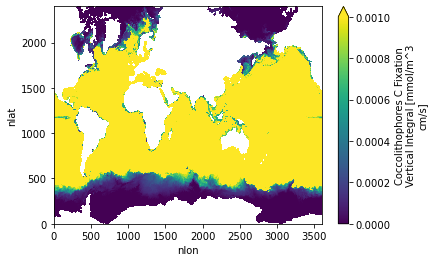

In [10]:
ds_ann.photoC_cocco_zint.isel(time=0).plot(vmin=0,vmax=0.001);

In [11]:
ds_ann['time'] = np.arange(1958,1958+34,1)

In [13]:
ds_ann['photoC_TOT_zint'] = ds_ann.photoC_sp_zint + ds_ann.photoC_cocco_zint + ds_ann.photoC_diat_zint

In [15]:
variables = variables + ['photoC_TOT_zint']

### Make timeseries for SA region

In [16]:
%%time
ts_SA_latband = xr.Dataset()
for v in variables:
    print(v)
    mask = ds_ann[v].where(ds_grid.TLAT < -40.).where(ds_grid.TLAT >-55.)
    ts_SA_latband[v] = esmlab.statistics.weighted_mean(mask, weights=area, dim=['nlat', 'nlon'])
    ts_SA_latband[v].attrs = ds_ann[v].attrs

ts_SA_latband = ts_SA_latband.compute()

cocco_N_lim_Cweight_avg_100m
sp_N_lim_Cweight_avg_100m
diat_N_lim_Cweight_avg_100m
cocco_Fe_lim_Cweight_avg_100m
diat_Fe_lim_Cweight_avg_100m
sp_Fe_lim_Cweight_avg_100m
cocco_C_lim_Cweight_avg_100m
diat_SiO3_lim_Cweight_avg_100m
cocco_P_lim_Cweight_avg_100m
sp_P_lim_Cweight_avg_100m
diat_P_lim_Cweight_avg_100m
cocco_light_lim_Cweight_avg_100m
diat_light_lim_Cweight_avg_100m
sp_light_lim_Cweight_avg_100m
sp_T_lim_Cweight_avg_100m
cocco_T_lim_Cweight_avg_100m
diat_T_lim_Cweight_avg_100m
photoC_sp_zint
photoC_cocco_zint
photoC_diat_zint
photoC_TOT_zint
CPU times: user 1min 17s, sys: 1min 56s, total: 3min 13s
Wall time: 3min 40s


### correlation with SAM

In [17]:
csv_file = '/glade/work/kristenk/SAM_index/SAM_indices.csv'
sam_indices = pd.read_csv(csv_file, header=None)
sam_indices.columns = ['year', 'ANN', 'AUT' , 'WIN', 'SPR', 'SUM']
sam_indices

,year,ANN,AUT,WIN,SPR,SUM
0,1957,-4.24,-2.52,-0.68,-3.55,-2.52
1,1958,-1.27,-2.97,-0.92,1.42,1.12
2,1959,0.47,-0.94,-1.22,3.20,0.31
3,1960,1.52,0.74,0.32,1.00,-0.08
4,1961,1.22,0.48,0.93,0.85,2.19
...,...,...,...,...,...,...
58,2015,4.13,1.43,3.19,1.75,2.19
59,2016,1.67,1.64,1.49,-0.31,-1.75
60,2017,1.67,1.34,1.15,1.42,2.33
61,2018,1.96,-0.81,-0.76,3.92,1.43


In [18]:
ts_SA_latband['time'] 

<xarray.DataArray 'time' (time: 34)>
array([1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
       1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991])
Coordinates:
  * time     (time) int64 1958 1959 1960 1961 1962 ... 1987 1988 1989 1990 1991

In [19]:
sam_indices.year.values[1:35]

array([1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968,
       1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979,
       1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991])

In [32]:
rate_vars = ['photoC_sp_zint','photoC_cocco_zint','photoC_diat_zint','photoC_TOT_zint']

In [33]:
for var in rate_vars:
    
    ts_SA_latband[var] = ts_SA_latband[var] * 0.01 * 86400.

### add SAM indices to the datasets

In [20]:
##### 'ANN', 'AUT' , 'WIN', 'SPR', 'SUM'
ts_SA_latband['SAM_ANN'] = xr.DataArray(sam_indices['ANN'].values[1:35],dims=('time'))
ts_SA_latband['SAM_AUT'] = xr.DataArray(sam_indices['AUT'].values[1:35],dims=('time'))
ts_SA_latband['SAM_WIN'] = xr.DataArray(sam_indices['WIN'].values[1:35],dims=('time'))
ts_SA_latband['SAM_SPR'] = xr.DataArray(sam_indices['SPR'].values[1:35],dims=('time'))
ts_SA_latband['SAM_SUM'] = xr.DataArray(sam_indices['SUM'].values[1:35],dims=('time'))

### same correlations in lat band (except for area)


In [21]:
variables

['cocco_N_lim_Cweight_avg_100m',
 'sp_N_lim_Cweight_avg_100m',
 'diat_N_lim_Cweight_avg_100m',
 'cocco_Fe_lim_Cweight_avg_100m',
 'diat_Fe_lim_Cweight_avg_100m',
 'sp_Fe_lim_Cweight_avg_100m',
 'cocco_C_lim_Cweight_avg_100m',
 'diat_SiO3_lim_Cweight_avg_100m',
 'cocco_P_lim_Cweight_avg_100m',
 'sp_P_lim_Cweight_avg_100m',
 'diat_P_lim_Cweight_avg_100m',
 'cocco_light_lim_Cweight_avg_100m',
 'diat_light_lim_Cweight_avg_100m',
 'sp_light_lim_Cweight_avg_100m',
 'sp_T_lim_Cweight_avg_100m',
 'cocco_T_lim_Cweight_avg_100m',
 'diat_T_lim_Cweight_avg_100m',
 'photoC_sp_zint',
 'photoC_cocco_zint',
 'photoC_diat_zint',
 'photoC_TOT_zint']

In [34]:
variables_lat  = variables + ['SAM_ANN','SAM_AUT','SAM_WIN','SAM_SPR','SAM_SUM']

numvars = len(variables_lat)
numvars

26

In [35]:
SA_lat_band_correlations = np.full((numvars,numvars),np.nan)
SA_lat_band_pvalues = np.full((numvars,numvars),np.nan)


i = 0
j = 0

for var1 in variables_lat:
    
    for var2 in variables_lat:
        
        slope, intercept, r_value, p_value, std_err = stats.linregress(ts_SA_latband[var1].sel(time=slice(1959,1991)),ts_SA_latband[var2].sel(time=slice(1959,1991)))
        
        SA_lat_band_correlations[j,i] = r_value
        SA_lat_band_pvalues[j,i] = p_value
        
        j = j + 1
        
    j = 0
    i = i + 1
    
SA_lat_band_correlations = xr.DataArray(SA_lat_band_correlations, dims=('x_vars','y_vars'))
SA_lat_band_pvalues = xr.DataArray(SA_lat_band_pvalues, dims=('x_vars','y_vars'))
SA_lat_band_correlations['x_vars'] = np.arange(0,numvars,1)
SA_lat_band_correlations['y_vars'] = np.arange(0,numvars,1)

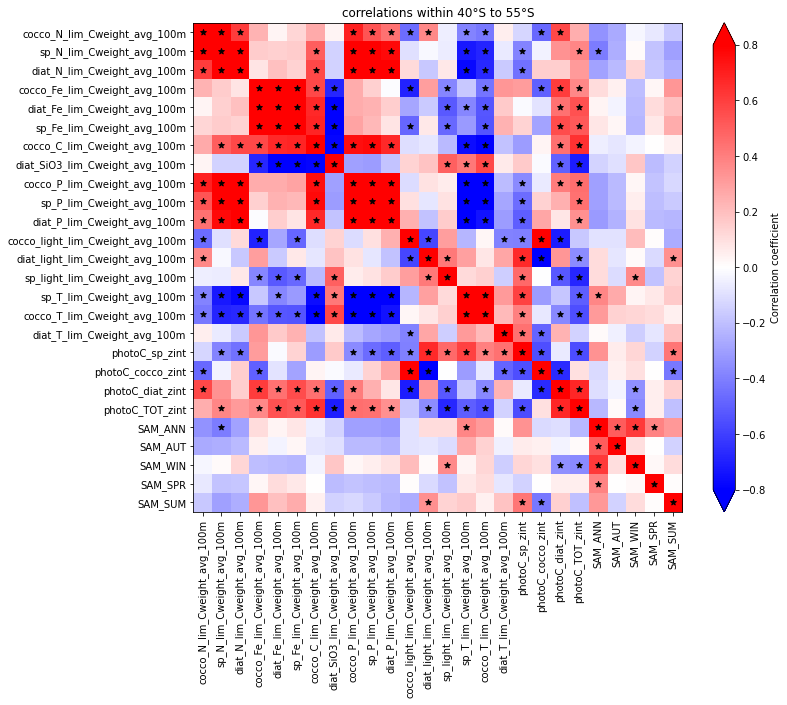

In [36]:
fig = plt.figure(figsize=(11,9))

ax = fig.add_subplot(1,1,1)

ax.set_title('correlations within 40°S to 55°S')
pc=ax.imshow(SA_lat_band_correlations.values,cmap='bwr',vmin=-0.8,vmax=0.8)
for i in range(len(variables_lat)):
    for j in range(len(variables_lat)):
        if SA_lat_band_pvalues[j,i].values < 0.05:
            ax.scatter(j, i, color="black", marker="*")

ax.set_xticks(np.arange(numvars))
ax.set_yticks(np.arange(numvars))
# ... and label them with the respective list entries
ax.set_xticklabels(variables_lat,rotation=90)
ax.set_yticklabels(variables_lat)
# ax.set_ylabel('Surface ${\sigma}_{\Theta}$')
# ax.set_xlabel('Month')
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Correlation coefficient')

In [38]:
slope, intercept, r_value, p_value, std_err = stats.linregress(ts_SA_latband['SAM_SUM'].sel(time=slice(1959,1991)),ts_SA_latband['photoC_cocco_zint'].sel(time=slice(1959,1991)))

pic_mod1 = -4*slope + intercept
pic_mod2 = 3.5*slope + intercept

In [39]:
r_value, p_value

(-0.42196146603281337, 0.01444631790657162)

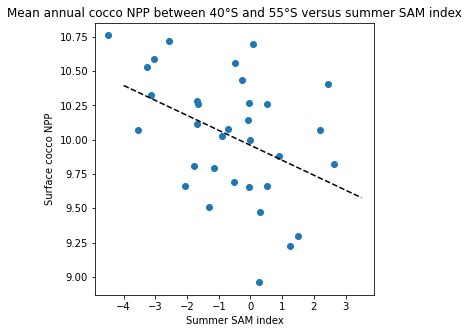

In [40]:
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(1,1,1)
ax.set_title('Mean annual cocco NPP between 40°S and 55°S versus summer SAM index')
ax.scatter(ts_SA_latband['SAM_SUM'].sel(time=slice(1959,1991)),ts_SA_latband['photoC_cocco_zint'].sel(time=slice(1959,1991)))
y_vals=[pic_mod1, pic_mod2]
x_vals=[-4,3.5]
ax.plot(x_vals,y_vals,color='black',linestyle='--')


ax.set(ylabel='Surface cocco NPP',xlabel='Summer SAM index');


In [54]:
slope, intercept, r_value, p_value, std_err = stats.linregress(ts_SA_latband['SAM_SUM'].sel(time=slice(1959,1991)),ts_SA_latband['photoC_sp_zint'].sel(time=slice(1959,1991)))

pic_mod1 = -4*slope + intercept
pic_mod2 = 3.5*slope + intercept

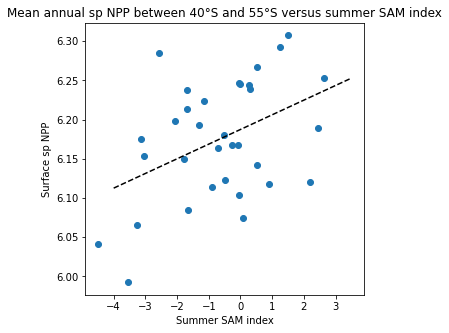

In [55]:
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(1,1,1)
ax.set_title('Mean annual sp NPP between 40°S and 55°S versus summer SAM index')
ax.scatter(ts_SA_latband['SAM_SUM'].sel(time=slice(1959,1991)),ts_SA_latband['photoC_sp_zint'].sel(time=slice(1959,1991)))
y_vals=[pic_mod1, pic_mod2]
x_vals=[-4,3.5]
ax.plot(x_vals,y_vals,color='black',linestyle='--')


ax.set(ylabel='Surface sp NPP',xlabel='Summer SAM index');


In [57]:
slope, intercept, r_value, p_value, std_err = stats.linregress(ts_SA_latband['SAM_SUM'].sel(time=slice(1959,1991)),ts_SA_latband['photoC_diat_zint'].sel(time=slice(1959,1991)))

pic_mod1 = -4*slope + intercept
pic_mod2 = 3.5*slope + intercept

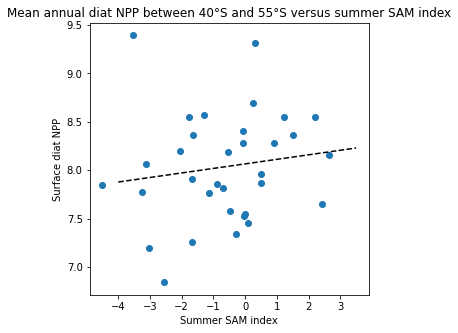

In [58]:
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(1,1,1)
ax.set_title('Mean annual diat NPP between 40°S and 55°S versus summer SAM index')
ax.scatter(ts_SA_latband['SAM_SUM'].sel(time=slice(1959,1991)),ts_SA_latband['photoC_diat_zint'].sel(time=slice(1959,1991)))
y_vals=[pic_mod1, pic_mod2]
x_vals=[-4,3.5]
ax.plot(x_vals,y_vals,color='black',linestyle='--')


ax.set(ylabel='Surface diat NPP',xlabel='Summer SAM index');


In [44]:
ts_SA_latband['photoC_diat_zint']

<xarray.DataArray 'photoC_diat_zint' (time: 34)>
array([11.49744899,  9.31264942,  8.4039107 ,  8.55134458,  8.15232697,
        8.55059061,  9.39322225,  8.36191537,  7.77733249,  7.85330929,
        8.06317678,  7.86619683,  7.5827022 ,  7.91374182,  7.81599479,
        7.65035332,  6.84081539,  7.45710658,  7.84663796,  7.53138254,
        7.55099741,  7.25792162,  8.28308543,  8.5528454 ,  8.20054802,
        8.19007267,  7.19660207,  7.34253973,  7.76841605,  8.69927733,
        8.36671453,  7.96280663,  8.27714095,  8.5689902 ])
Coordinates:
  * time     (time) int64 1958 1959 1960 1961 1962 ... 1987 1988 1989 1990 1991
Attributes:
    long_name:     Diatom C Fixation Vertical Integral
    units:         mmol/m^3 cm/s
    grid_loc:      2110
    cell_methods:  time: mean

In [50]:
slope, intercept, r_value, p_value, std_err = stats.linregress(ts_SA_latband['photoC_diat_zint'].sel(time=slice(1959,1991)),ts_SA_latband['photoC_cocco_zint'].sel(time=slice(1959,1991)))

pic_mod1 = 6.5*slope + intercept
pic_mod2 = 9.5*slope + intercept

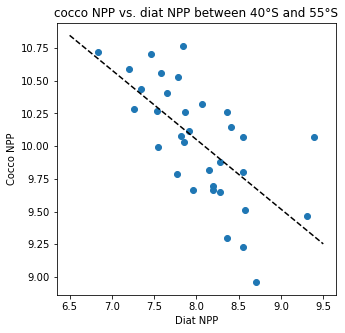

In [51]:
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(1,1,1)
ax.set_title('cocco NPP vs. diat NPP between 40°S and 55°S')
ax.scatter(ts_SA_latband['photoC_diat_zint'].sel(time=slice(1959,1991)),ts_SA_latband['photoC_cocco_zint'].sel(time=slice(1959,1991)))
y_vals=[pic_mod1, pic_mod2]
x_vals=[6.5,9.5]
ax.plot(x_vals,y_vals,color='black',linestyle='--')


ax.set(ylabel='Cocco NPP',xlabel='Diat NPP');


In [52]:
ts_SA_latband['photoC_sp_zint'].sel(time=slice(1959,1991))

<xarray.DataArray 'photoC_sp_zint' (time: 33)>
array([6.23936014, 6.16814415, 6.11998821, 6.25362438, 6.14970942,
       5.99228299, 6.0846701 , 6.06601175, 6.11455046, 6.17476096,
       6.14247218, 6.12262653, 6.21380848, 6.16425613, 6.18871729,
       6.28499719, 6.07480946, 6.04144632, 6.10355463, 6.24521451,
       6.23747522, 6.11745973, 6.29255672, 6.19809296, 6.18083554,
       6.1539637 , 6.16787233, 6.22398791, 6.24364547, 6.30736732,
       6.26716748, 6.24605561, 6.19364132])
Coordinates:
  * time     (time) int64 1959 1960 1961 1962 1963 ... 1987 1988 1989 1990 1991
Attributes:
    long_name:     Small Phyto C Fixation Vertical Integral
    units:         mmol/m^3 cm/s
    grid_loc:      2110
    cell_methods:  time: mean

In [ ]:
slope, intercept, r_value, p_value, std_err = stats.linregress(ts_SA_latband['photoC_sp_zint'].sel(time=slice(1959,1991)),ts_SA_latband['photoC_cocco_zint'].sel(time=slice(1959,1991)))

pic_mod1 = 6*slope + intercept
pic_mod2 = 6.5*slope + intercept

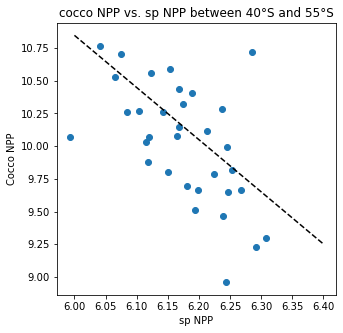

In [53]:
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(1,1,1)
ax.set_title('cocco NPP vs. sp NPP between 40°S and 55°S')
ax.scatter(ts_SA_latband['photoC_sp_zint'].sel(time=slice(1959,1991)),ts_SA_latband['photoC_cocco_zint'].sel(time=slice(1959,1991)))
y_vals=[pic_mod1, pic_mod2]
x_vals=[6,6.4]
ax.plot(x_vals,y_vals,color='black',linestyle='--')


ax.set(ylabel='Cocco NPP',xlabel='sp NPP');